# BEE 4750 Lab 2: Uncertainty and Monte Carlo

**Name**:

**ID**:

> **Due Date**
>
> Wednesday, 9/25/24, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [49]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/github/Cornell/BEE-5750/lab2-duckduckgogogo`


In [50]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Overview

In this lab, we will use Monte Carlo analysis to analyze a version of
the culmination of every episode of the long-running game show [The
Price Is Right](https://en.wikipedia.org/wiki/The_Price_Is_Right): the
[Showcase](https://en.wikipedia.org/wiki/The_Price_Is_Right#Showcase).

Monte Carlo methods involve the simulation of random numbers from
probability distributions. In an environmental context, we often
propagate these random numbers through some more complicated model and
then compute a resulting statistic which is relevant for assessing
performance or risk, such as an average outcome or a particular
quantile.

You should always start any computing with random numbers by setting a
“seed,” which controls the sequence of numbers which are generated
(since these are not *really* random, just “pseudorandom”). In Julia, we
do this with the `Random.seed!()` function.

In [51]:
Random.seed!(1)

TaskLocalRNG()

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Probability Distributions and Julia

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [52]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 3
 5
 4
 6
 2
 5
 5
 5
 2
 4
 3
 2
 ⋮
 2
 3
 3
 3
 6
 5
 5
 6
 3
 6
 6
 6

And then we can plot a histogram of these rolls:

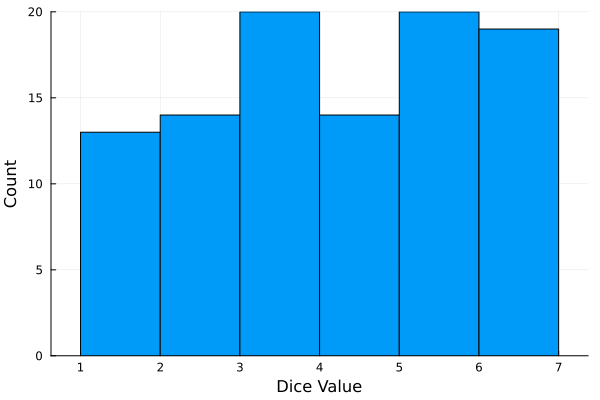

In [53]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

### Instructions

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercise (3 Points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. Make the following
assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

We’ll assume that the distribution of all showcases offered by the show
is given as truncated normal distribution, which means a normal
distribution which has an upper and/or lower bound. `Distributions.jl`
makes it easy to specify truncations on any distribution, not just
normal distributions. For example, we’ll use the distribution shown in
<a href="#fig-values" class="quarto-xref">Figure 1</a> for the showcase
values (you can just directly use the `showcase_dist` distribution in
your lab code).

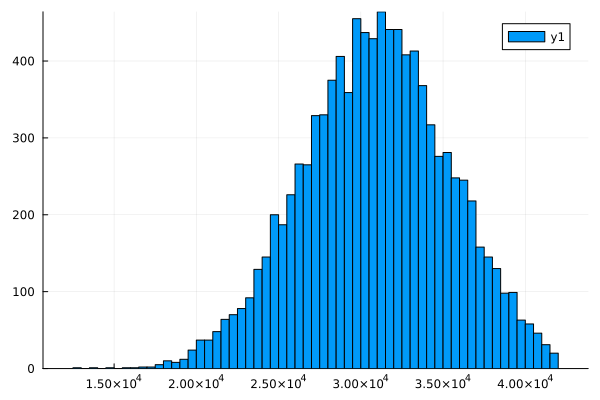

In [54]:
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
showcase_samples = rand(showcase_dist, 10_000)
histogram(showcase_samples)

Find your expected winnings if you bid \$35,000. Plot the outcomes of
your Monte Carlo experiment (iterations vs. running estimate). How did
you decide how many samples to use?

## <font color='blue'> **SOLUTION - Lab 2** </font>

To simulate our expected winnings, we run many iterations of our showcase, each time keeping track of how much money we won. We then average out our winnings across all these trials to get our expected winnings. 

In each iteration of the showcase, we sample from *showcase_dist* to get the true value of the showcase. Recall that our bid is fixed at $35,000. Using the logic in the problem statement, we compare the true value of the showcase to our bid in order to determine how much money we win. Specifically, if the true value is within $250 of $35,000 then we win double the value of the showcase value. Else if we guess under the showcase value and outbid our opponent, then we win the showcase value. Otherwise we win $0. 

Note that if we guess less than the value of the showcase but not within $250 of it, there is a linear probability of being outbid that we evaluate in the following manner: first we evaluated the probability of being outbid by taking the difference between the true value of the showcase and our bid then dividing that difference by the true value of the showcase, then multiplying that by 100. This gives us a number between 0 and 100 inclusive that represents the probability of being outbid. We then draw a random number between 0 and 100, inclusive. If this value is less than or equal to the probability that we are outbid, then we do not win any money. If this value is greater than the probability that we are outbid, then we win the value of the showcase. 

When we ran this experiment, we found that the expected winnings are approximately $7086.55. See below for the plot of the outcomes of the Monte Carlo experiment. I decided how many samples to use by increasing the number of iterations by a factor of 10 until the plot leveled out to a relatively consistent and flat running estimate. I ran it with 10,000 iterations though I believe anything over 7,500 iterations to be sufficient.

In [167]:
function sim_showcase()
    myGuess = 35000
    myWinnings = 0
    probabilityOutbid=1
    trueValue = rand(showcase_dist)

    if abs(trueValue - myGuess) <= 250  # Case 1: Guess within $250 of showcase value --> win twice the value of the showcase
        myWinnings = 2 * trueValue
    elseif myGuess <= trueValue # Case 2: Guess less than showcase value --> probability that win showcase changes linearly
        probabilityOutbid = ((trueValue - myGuess)/trueValue) * 100  # Probability that opponent outbids us
        opponentBid = rand(0:100)  # Draw random number between 0 and 100
        if opponentBid > probabilityOutbid
            myWinnings = trueValue
        else
            myWinnings = 0
        end
    else  # Case 3: Guess more than showcase value --> don't win anything
        myWinnings = 0
    end
    return myWinnings
end

sim_showcase (generic function with 1 method)

In [168]:
list_winnings = []
list_avgWinnings = []
list_iterations = []
for i in 1:10000
    thisWinnings = sim_showcase()
    push!(list_winnings, thisWinnings)
    avg_winnings = mean(list_winnings)
    push!(list_avgWinnings, avg_winnings)
    push!(list_iterations, i)
end
@show avg_winnings

avg_winnings = 7849.847068786812


7849.847068786812

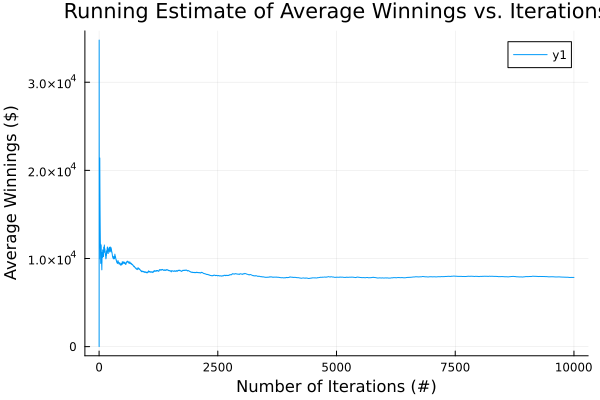

In [171]:
plot(list_iterations, list_avgWinnings, title="Running Estimate of Average Winnings vs. Iterations")
xlabel!("Number of Iterations (#)")
ylabel!("Average Winnings (\$)")


## References

Put any consulted sources here, including classmates you worked with/who
helped you.

Peter Thais